출처 : https://www.dacon.io/competitions/official/235712/codeshare/2453?page=1&dtype=recent

In [1]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU

os.environ['CUDA_VISIBLE_DEVICES']="2"

In [2]:
#파일 경로를 설정해줍니다.
import os
os.chdir('./open')

In [3]:
train_x_df=pd.read_csv('train_x_df.csv')
train_y_df=pd.read_csv('train_y_df.csv')
test_x_df=pd.read_csv('test_x_df.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [4]:
# time 수로 나누어 samples 수 확인
print(len(train_x_df)/1380, len(train_y_df)/120)

7661.0 7661.0


In [5]:
print(train_x_df.sample_id.nunique())
print(train_y_df.sample_id.nunique())

7661
7661


In [6]:
train_x_df.head(2)

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188


In [7]:
train_y_df.head(2)

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.999389,0.99963,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1,9,0.999593,1.00000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999


In [8]:
#submission 개수 1380 *535
len(test_x_df)/1380

535.0

### 데이터 재구성

In [9]:
train_x_df.iloc[:,3:].values

array([[9.83614206e-01, 9.83614206e-01, 9.83127594e-01, ...,
        9.85464361e-03, 8.48178868e-04, 6.77175522e+00],
       [9.83244658e-01, 9.83611703e-01, 9.82452571e-01, ...,
        1.61369797e-02, 6.97290583e-04, 5.56518841e+00],
       [9.82693970e-01, 9.83611703e-01, 9.82403278e-01, ...,
        1.41660506e-02, 9.05190827e-04, 7.22545862e+00],
       ...,
       [1.00027728e+00, 1.00038815e+00, 9.99833643e-01, ...,
        7.81856537e-01, 3.60461026e-01, 6.50189362e+01],
       [1.00016630e+00, 1.00022185e+00, 9.99778211e-01, ...,
        6.70954883e-01, 2.96588272e-01, 5.34865646e+01],
       [1.00000000e+00, 1.00055456e+00, 9.99889135e-01, ...,
        1.26427865e+00, 7.35242546e-01, 1.32617462e+02]])

In [10]:
#데이터프레임을 tensorflow 모델에 적합하게 reshape
train_x = tf.reshape(train_x_df.iloc[:,3].values, [-1, 1380, 1])
train_y = tf.reshape(train_y_df.iloc[:,3].values, [-1, 120, 1])
test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1])

In [17]:
#아래와 같이 train 데이터에서 시가의 마지막 값이 모두 1임을 확인
train_x[:, 1379, 0]

<tf.Tensor: shape=(7661,), dtype=float64, numpy=array([1., 1., 1., ..., 1., 1., 1.])>

In [12]:
test_x[:, 1379, 0]

<tf.Tensor: shape=(535,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

### EDA

In [13]:
#재구성한 뒤 train_x, train_y, test_x의 shape를 확인
print(train_x.shape, train_y.shape, test_x.shape)

(7661, 1380, 1) (7661, 120, 1) (535, 1380, 1)


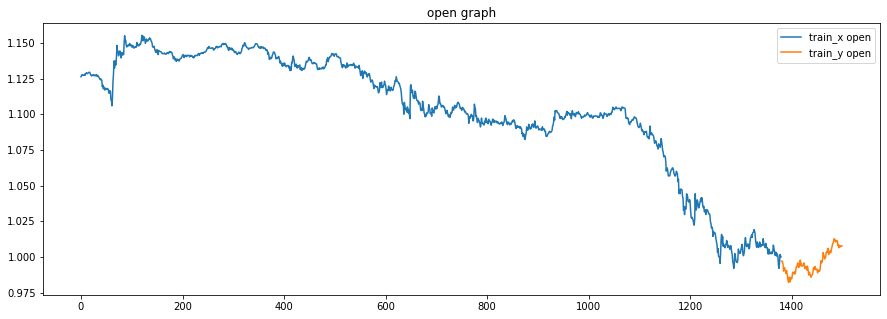

In [15]:
row=1
row+=1
plt.figure(figsize=(15,5))


plt.plot(train_x[row,:,0], label='train_x open')
plt.plot(np.arange(train_x.shape[1],train_x.shape[1]+ train_y.shape[1]), train_y[row, :, 0], label='train_y open')
plt.legend()
plt.title('open graph')
plt.show()

### 자기 회귀 모델 구성

In [18]:
train_x.shape

TensorShape([7661, 1380, 1])

In [23]:
input_window=170
output_window=60
window=input_window + output_window

train_window_x= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, input_window, 1))
train_window_y= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, output_window, 1))
print(train_window_x.shape, train_window_y.shape)

for example in range(train_x.shape[0]):
    
    for start in range(0,  train_x.shape[1]-(input_window + output_window), 230):
        end=start+input_window
        train_window_x[example, start//230, :, :] = train_x[example, start: end               , :]
        train_window_y[example, start//230, :, :] = train_x[example, end  : end+ output_window, :]

(7661, 5, 170, 1) (7661, 5, 60, 1)


In [24]:
new_train_x=tf.reshape(train_window_x, [-1, 170, 1])
new_train_y=tf.reshape(train_window_y, [-1, 60, 1])

In [25]:
time        = new_train_x.shape[1] #170
num_features= new_train_x.shape[2] #1
OUT_STEPS   = new_train_y.shape[1] #60

#####층 쌓기###########


model=Sequential([
LSTM(32, input_shape=(time, num_features), dropout=0.2, recurrent_dropout=0.2),
Dense(OUT_STEPS * num_features), 
Reshape([OUT_STEPS, num_features])
]).



#######Compile 구성하기################


model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)


######################
history = model.fit(new_train_x, new_train_y, epochs=30, batch_size=128, validation_split = 0.2, verbose=0, callbacks=[PrintDot(), early_stop, save_best_only , reduceLR])


..............................

In [26]:
print(new_train_x.shape, new_train_y.shape)

(38305, 170, 1) (38305, 60, 1)


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 60)                1980      
_________________________________________________________________
reshape (Reshape)            (None, 60, 1)             0         
Total params: 6,332
Trainable params: 6,332
Non-trainable params: 0
_________________________________________________________________


### 예측하기

In [28]:
#기존 test_x를 다시 불러옵니다.
test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1])

In [29]:
auto_x=test_x
auto_x.shape

TensorShape([535, 1380, 1])

In [30]:
submission=np.zeros((535, 120, 9))

In [31]:
end_=120
output_window = 60

for i in range(end_//output_window):
    start_ = i *output_window
    next_ = model.predict(auto_x[:, -170:, :])
    auto_x=tf.concat([auto_x, next_], axis=1)
    print(auto_x.shape)
    submission[:, start_ : start_ + output_window, :] = next_

(535, 1440, 1)
(535, 1500, 1)


In [32]:
submission.shape

(535, 120, 9)

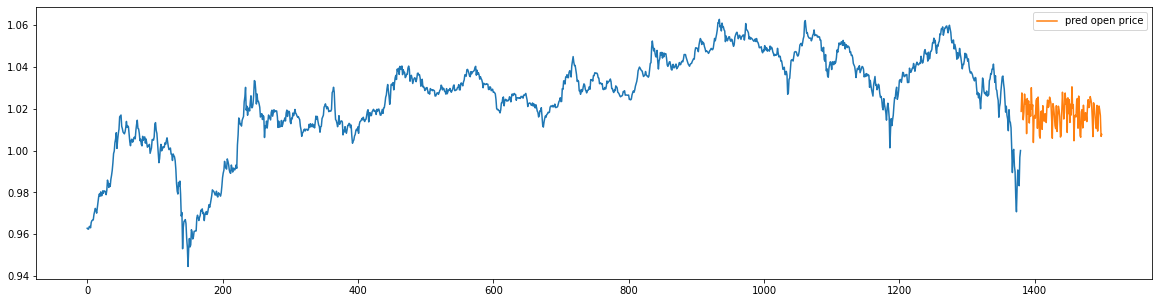

In [33]:
row +=1
plt.figure(figsize=(20,5))

plt.plot(test_x[row,:, 0])
plt.plot(np.arange(test_x.shape[1], test_x.shape[1]+ submission.shape[1]), submission[row, :, 0], label='pred open price')
plt.legend()
plt.show()